### In this project, I'm harnessing the power of data to forecast daily staff requirements for optimal customer service. 

### Drawing insights from comprehensive historical data, I've used Pandas to cleanse and refine the data, ensuring its utmost accuracy. 

### Along with outlining the key considerations for the company, I've identified actionable steps to streamline operations and enhance business performance.



In [375]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import chart_studio.plotly as py
from plotly import __version__
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
%matplotlib inline
import matplotlib.dates as mpl_dates
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import cufflinks as cf
# For offline use
cf.go_offline()

In [376]:
df=pd.read_csv('chat_demand.csv')

In [377]:
df.head()

,date,eligible_users,chats
0,2017-01-01,10000,61.0
1,2017-01-02,10000,126.0
2,2017-01-03,10000,119.0
3,2017-01-04,10000,118.0
4,2017-01-05,10000,117.0


In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            212 non-null    object 
 1   eligible_users  212 non-null    int64  
 2   chats           181 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.1+ KB


### Checking null values

<AxesSubplot:>

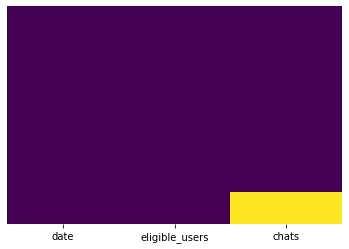

In [379]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [380]:
df.isna().sum()

date               0
eligible_users     0
chats             31
dtype: int64

### Checking duplicates

In [381]:
df1=df.loc[df['date'].duplicated()]
df1.count()

date              0
eligible_users    0
chats             0
dtype: int64

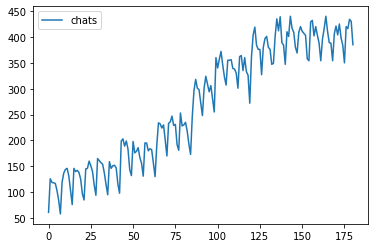

In [382]:
df.plot(y='chats')
plt.show()

In [383]:
df_index=df.set_index('date')
df_index.head()

,eligible_users,chats
date,,
2017-01-01,10000,61.0
2017-01-02,10000,126.0
2017-01-03,10000,119.0
2017-01-04,10000,118.0
2017-01-05,10000,117.0


<AxesSubplot:xlabel='date'>

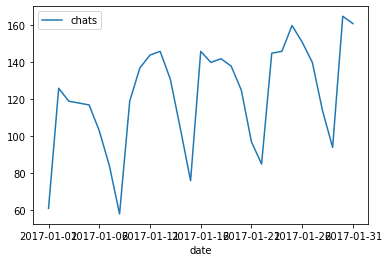

In [384]:
df1=df_index['2017-01-01':'2017-01-31']
df1.plot(y='chats')

<AxesSubplot:xlabel='date'>

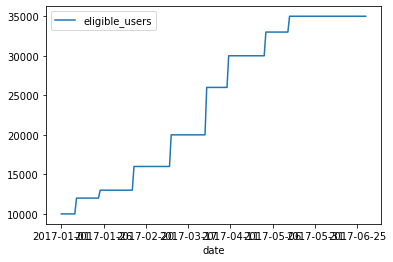

In [385]:
df2=df_index['2017-01-01':'2017-06-30']
df2.plot(y='eligible_users')

<AxesSubplot:xlabel='date'>

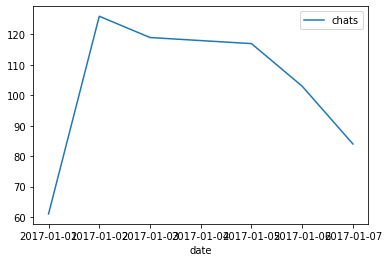

In [386]:
df3=df_index['2017-01-01':'2017-01-07']
df3.plot(y='chats')

# Findings on the dataset


<b>
    
    
-- It is going little shallower in the beginning and then the rate of <font color='blue'>trend starts to increase.</font> 
    
    
    
    

    
-- The patterns are <font color='blue'>almost similar</font> throughout the time series.
    
-- The chats volume <font color='blue'>dropping after almost equal intervals of time</font> . We see couple of spikes in the chats too. 
    
    
-- It looks like we have <font color='blue'>more demand during Mon-Wed</font>. During the weekends chat volumes are dropping.
    


    
<b>



### Format the Data

<b>Note<b>: Facebook wants the column names to be changed to DS and Y because inside of the prophet library these are essentially hard coded in for a lot of their calculations.

In [387]:
df.drop('eligible_users',axis=1,inplace=True)
df.columns=['ds','y']
#ds column to a datetime object
df['ds'] = pd.to_datetime(df['ds'])


# Why Prophet Model?

<b>
    
-- The dataset has a <font color='blue'>strong seasonality and prophet works best for this situation</font>.
    
    
-- Facebook prophet delivers <font color='blue'>high-quality forecasts</font> and robust to outliers and missing values.
    
    
-- It also got fair amount plotting capabilities. It is quick
and good for datasets with daily observations.
    

-- Prophet only <font color='blue'>requires a few lines of code to produce its forecast results</font>.
    

    
<b>

###  Train/Test Split

In [388]:
train=df.iloc[:166]
test=df.iloc[166:181]
#Create and Fit Model
model=Prophet(changepoint_prior_scale=0.5, changepoint_range=0.8,seasonality_mode='multiplicative')
model.fit(train)
# Placeholder to hold our future predictions
future=model.make_future_dataframe(periods=15)
#predict and fill in the future
#yhat is the predicted output
forecast=model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
166,2017-06-16,406.481217,384.395009,428.446592
167,2017-06-17,375.159183,353.355811,397.978995
168,2017-06-18,340.844848,317.888156,360.545469
169,2017-06-19,425.240171,403.924088,448.798758
170,2017-06-20,435.823797,413.965891,455.431512
171,2017-06-21,435.091814,414.635151,456.792379
172,2017-06-22,426.807364,405.172307,446.463909
173,2017-06-23,409.763718,389.570728,433.357345
174,2017-06-24,378.185254,356.784457,401.034075
175,2017-06-25,343.590973,322.372643,365.160297


# Forecast Evaluations

<AxesSubplot:xlabel='ds'>

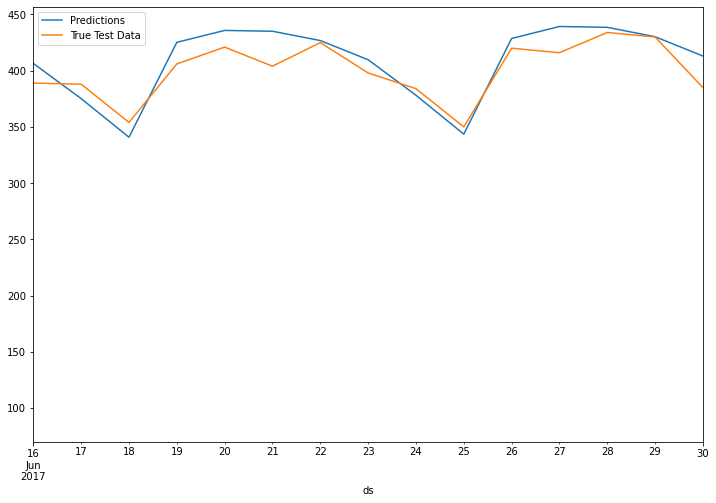

In [389]:
ax=forecast.plot(x='ds',y='yhat',label='Predictions',legend=True, figsize=(12,8))
test.plot(x='ds',y='y',label='True Test Data',legend=True,ax=ax,xlim=('2017-06-16','2017-06-30'))

<b>
    
-- Visually the predictions look <font color='red'>pretty close to true test data</font>.
    
-- We shall calculate RMSE and MAPE to compare predictions to test values to see how well the model performed.
    
<b>

In [390]:
from statsmodels.tools.eval_measures import rmse
#we only want the test rows and yhat column
predictions=forecast.iloc[-15:]['yhat']
#grab the prediction values
predictions

166    406.481217
167    375.159183
168    340.844848
169    425.240171
170    435.823797
171    435.091814
172    426.807364
173    409.763718
174    378.185254
175    343.590973
176    428.662315
177    439.327085
178    438.585206
179    430.230313
180    413.046218
Name: yhat, dtype: float64

In [391]:
test['y']

166    389.0
167    388.0
168    354.0
169    406.0
170    421.0
171    404.0
172    425.0
173    398.0
174    384.0
175    350.0
176    420.0
177    416.0
178    434.0
179    430.0
180    385.0
Name: y, dtype: float64

In [392]:
#compare our predictions to test values
rmse(predictions,test['y'])

16.007419456219058

In [393]:
test.mean()

<ipython-input-393-a428e52fa3ce>:1: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



y    400.266667
dtype: float64

<b>
<em>

    
-- Prophet actually includes its own diagnostic functionality in order to perform whats known as cross-validation.
  
    
-- So right now, we are essentially only testing the very last portion of our data frame. But Prophet diagnostics allows us to perform cross-validation and run and evaluate the model on several sections of the actual dataset


</em>
</b>

In [394]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric


<b>
There's essentially three main things we need to define.
    
1. An Initial training period
2. The period length that we're going to perform the cross-validation for
3. Horizon of prediction for essentially each fold.
    
<b>


In [395]:

df_cv=cross_validation(model, initial='100 days', period='100 days', horizon='15 days')

INFO:fbprophet:Making 1 forecasts with cutoffs between 2017-05-31 00:00:00 and 2017-05-31 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

In [396]:
df_cv


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-06-01,435.958169,413.550827,456.609328,407.0,2017-05-31
1,2017-06-02,416.967112,393.682616,438.923619,403.0,2017-05-31
2,2017-06-03,385.422603,364.317880,408.012131,358.0,2017-05-31
3,2017-06-04,347.646396,325.886520,370.248015,354.0,2017-05-31
4,2017-06-05,441.052918,418.657149,463.202746,429.0,2017-05-31
5,2017-06-06,452.631305,431.328049,475.564154,432.0,2017-05-31
6,2017-06-07,453.441464,431.440735,475.320322,402.0,2017-05-31
7,2017-06-08,448.714003,426.173999,471.227515,420.0,2017-05-31
8,2017-06-09,429.116497,406.749078,451.766055,403.0,2017-05-31
9,2017-06-10,396.606308,375.189825,419.355432,388.0,2017-05-31


In [397]:
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,838.575553,28.958169,28.958169,0.071150,0.071150,0.0
1,2 days,195.080221,13.967112,13.967112,0.034658,0.034658,1.0
2,3 days,751.999178,27.422603,27.422603,0.076599,0.076599,0.0
3,4 days,40.368278,6.353604,6.353604,0.017948,0.017948,1.0
4,5 days,145.272830,12.052918,12.052918,0.028095,0.028095,1.0
5,6 days,425.650728,20.631305,20.631305,0.047758,0.047758,1.0
6,7 days,2646.224244,51.441464,51.441464,0.127964,0.127964,0.0
7,8 days,824.493951,28.714003,28.714003,0.068367,0.068367,0.0
8,9 days,682.071437,26.116497,26.116497,0.064805,0.064805,0.0
9,10 days,74.068536,8.606308,8.606308,0.022181,0.022181,1.0


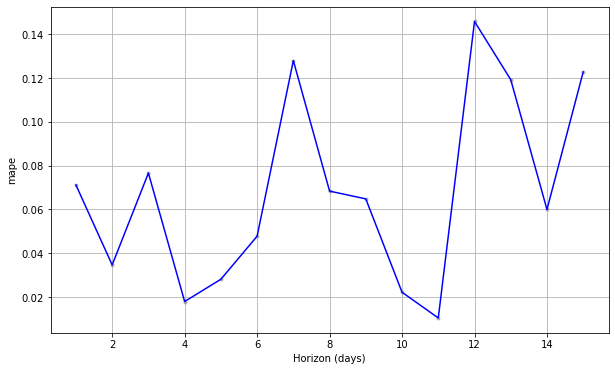

In [398]:
plot_cross_validation_metric(df_cv,metric='mape');

# Accuracy of the model

<b>
   
-- We are determining the model precision by using cross_validation on historical data, basically forecasting a given horizon (15 days) every period (100 days) after initial data (100 days). 
    
-- By computing error measures for predicted values and original values we can see how close our predicted values are to the real values.
    
-- Using mean absolute percentage error (MAPE), root mean squared error (RMSE)  we can see the  absolute percent error for each prediction.
 
<b>

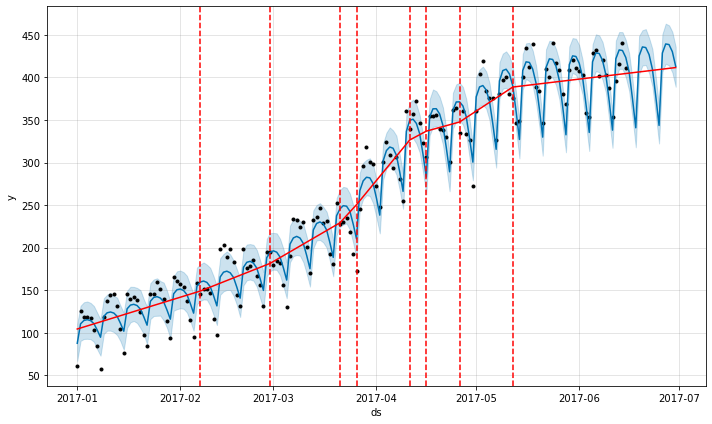

In [399]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

<b>
Prophet can highlight the points (<font color='red'>red dotted lines</font>) where there is a change in trend. Which means we can then go back on our data set and figure out what's happening at these particular timestamps.
<b>

C:\Users\djpra\Documents\DS\anaconda\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



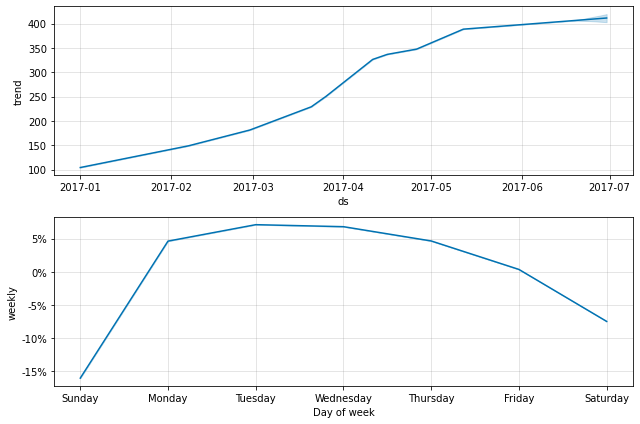

In [400]:
model.plot_components(forecast);


# Forecasting for the July Month

In [401]:
forecast_july=model.predict(df)
forecast_july.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2017-01-01,104.454374,66.827273,108.688334,104.454374,104.454374,-0.160444,-0.160444,-0.160444,-0.160444,-0.160444,-0.160444,0.0,0.0,0.0,87.695305
1,2017-01-02,105.660865,90.797705,132.800819,105.660865,105.660865,0.046231,0.046231,0.046231,0.046231,0.046231,0.046231,0.0,0.0,0.0,110.545699
2,2017-01-03,106.867356,92.569576,136.872255,106.867356,106.867356,0.071039,0.071039,0.071039,0.071039,0.071039,0.071039,0.0,0.0,0.0,114.459121
3,2017-01-04,108.073847,94.259558,135.137447,108.073847,108.073847,0.068014,0.068014,0.068014,0.068014,0.068014,0.068014,0.0,0.0,0.0,115.424366
4,2017-01-05,109.280338,92.665454,137.681249,109.280338,109.280338,0.046478,0.046478,0.046478,0.046478,0.046478,0.046478,0.0,0.0,0.0,114.359448


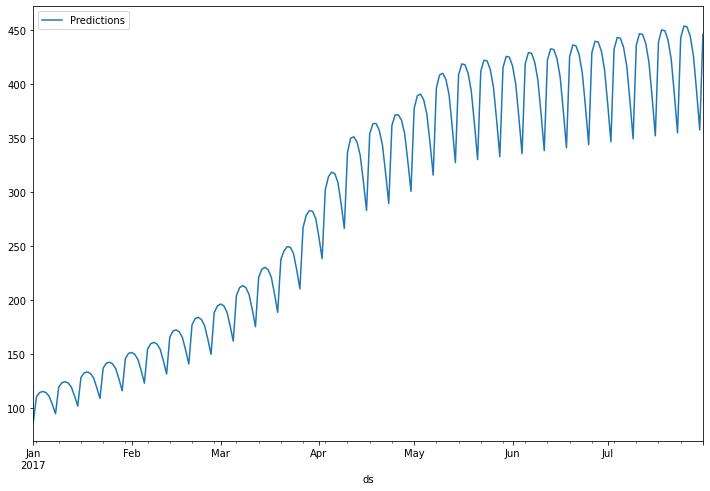

In [402]:
ax=forecast_july.plot(x='ds',y='yhat',label='Predictions',legend=True, figsize=(12,8))

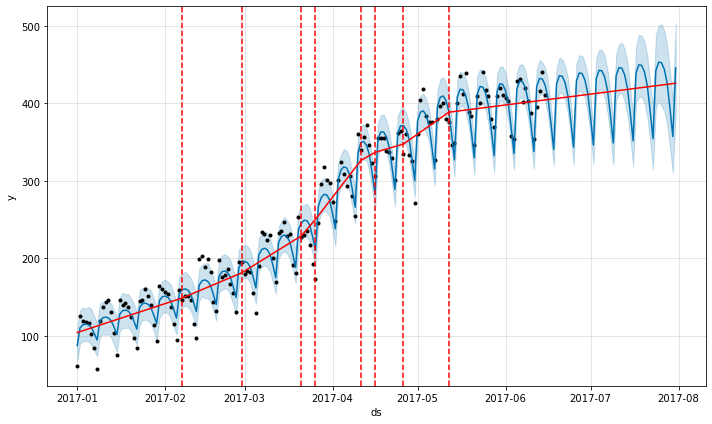

In [403]:
fig = model.plot(forecast_july)
a = add_changepoints_to_plot(fig.gca(), model, forecast_july)

C:\Users\djpra\Documents\DS\anaconda\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



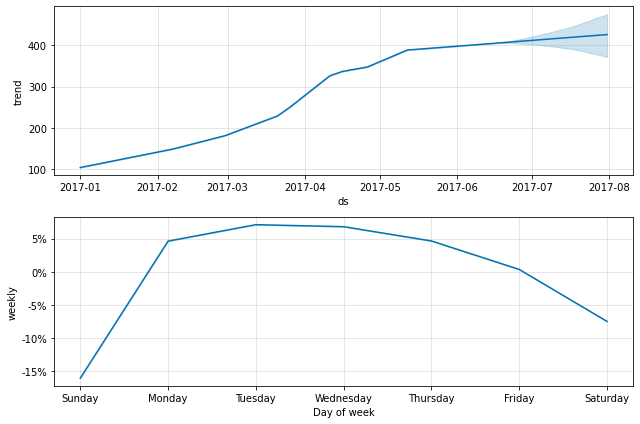

In [404]:
model.plot_components(forecast_july);


<b>

    
<b>

In [405]:
#forecast_july=forecast_july[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#update_csv = pd.DataFrame(forecast_july).to_csv('chat_demand.csv')

In [406]:
forecast_july.set_index('ds',inplace=True)
forecast_july.index=pd.to_datetime(forecast_july.index)
d1=forecast_july.resample('M').mean()
#this connects js to notebook
init_notebook_mode(connected=True)
#plotly essentially connects pandas and python to the interactive js library
d1[['yhat', 'yhat_lower', 'yhat_upper']].iplot(kind='surface',colorscale='rdylbu',title='The Average chat range for each month')

In [407]:
d1[['yhat']].iplot(yTitle='Chats',xTitle='Months', title='The Average no of chats for each month')

In [408]:
#average volume per day
forecast_july['yhat'].mean()

292.80274734329737

In [339]:
#average volume per month.
forecast_july['yhat'].resample('M').mean()

ds
2017-01-31    122.377811
2017-02-28    160.862075
2017-03-31    222.572575
2017-04-30    325.389626
2017-05-31    388.303994
2017-06-30    405.519512
2017-07-31    416.512400
Freq: M, Name: yhat, dtype: float64

In [340]:
#average annual volume
(forecast_july['yhat'].resample('M').mean()).mean()

291.64828479834824

In [341]:
#average volume in july
july=forecast_july['2017-07-01':'2017-07-31']
july['yhat'].mean()

416.51239960525663

<AxesSubplot:title={'center':'Percentage change in average monthly chats'}, xlabel='Monthly', ylabel='values in %'>

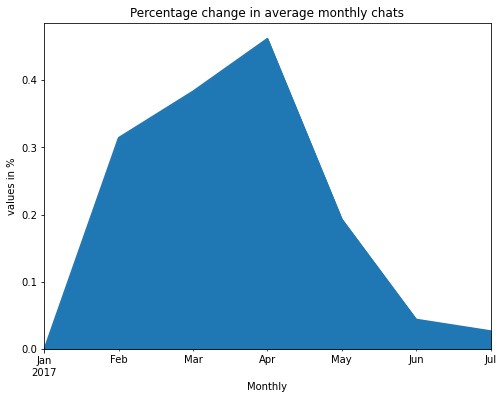

In [342]:
#percentage change
plt.figure(figsize=(8,6))
growth=forecast_july['yhat'].resample('M').mean().pct_change()
growth.plot(kind='area',xlabel='Monthly',ylabel='values in %', title='Percentage change in average monthly chats')
  

We can see the growth rate declining after April. Probably due to seasonal change. There might be various reasons like users are interested in going to a clinic as it is sunny and bright outside or some might be on vacation.

<b>

### Let's assume we are open for 8 hours and time spent on each user is  15 mins.

<b>

In [343]:
working_minutes=8*60
Appointment_time=15
users_per_nurse=working_minutes/Appointment_time
no_of_nurses=july['yhat']/users_per_nurse
no_of_nurses

ds
2017-07-01    11.912854
2017-07-02    10.823034
2017-07-03    13.502639
2017-07-04    13.838449
2017-07-05    13.814956
2017-07-06    13.551664
2017-07-07    13.010272
2017-07-08    12.007419
2017-07-09    10.908851
2017-07-10    13.609581
2017-07-11    13.947927
2017-07-12    13.924125
2017-07-13    13.658632
2017-07-14    13.112851
2017-07-15    12.101983
2017-07-16    10.994667
2017-07-17    13.716523
2017-07-18    14.057405
2017-07-19    14.033293
2017-07-20    13.765599
2017-07-21    13.215429
2017-07-22    12.196548
2017-07-23    11.080483
2017-07-24    13.823465
2017-07-25    14.166882
2017-07-26    14.142462
2017-07-27    13.872566
2017-07-28    13.318007
2017-07-29    12.291113
2017-07-30    11.166300
2017-07-31    13.930407
Name: yhat, dtype: float64

# Points to consider


- Do users need an appointment before initiating a chat? Or they can just initiate whenever they want during the operating hours.

    
- As we have a lot of employees booking appointments for Monday, we might have more last-minute cancellations when compared to other days. We need to consider this while staffing and having the no. of cancellations for each day of the previous months would help in making more accurate forecasting.
   
    
- Generally during Thu and Friday people tend to rush in before the weekends just to get it done with this and not keep it until next week again. I think we would see fewer cancellations when compared to Monday.
    
    
- No-shows usually result in underutilized medical resources and increased healthcare costs. So, we need to ensure that we reduce our virtual clinic idle times for improving the efficiency and accessibility of our healthcare delivery systems.
    
    
- The holidays need to be taken into consideration. No of working hours in a day
    
    
- Whether chats are open throughout the day or there are any breaks
    

- Average engagement time for each user
    
    
- Abandonment ratio: User dropping the chat before being answered
    
    
- Average wait time before a nurse takes care of the user
    
    
- Average time per chat  vs number of chats
    
    
- What percentage of chat volume arrives during each working hour of a day. This will help predict the busy hours. 



# Impact on Company's operations

- We don’t want our resources to be over or under-utilized. If the results show that we were able to utilize our resources properly that means we were able to maintain good productivity.


- Full utilization of resources gives us a better ROI. Basically if there is a positive change in the company’s revenue then probably our model might have played an important role


- If we see a drop in the operations cost then that is also an indication.


- If our clients are getting what they were looking for and satisfied with our service. 


- The difference between the projected volume of chats vs actual volume of chats. 


- How well our supply matched the demand.


### Improvement

<em>
    
- As we are doing a short term forecasting here, SARIMA (Seasonal Autoregressive Integrated Moving Average) model can also yield better results, and usually works well for data containing trends and seasonality.
</em>